<a href="https://colab.research.google.com/github/Janortop5/Janortop5/blob/main/Henry_ML_Lagos_Lectures_JAX_FLAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

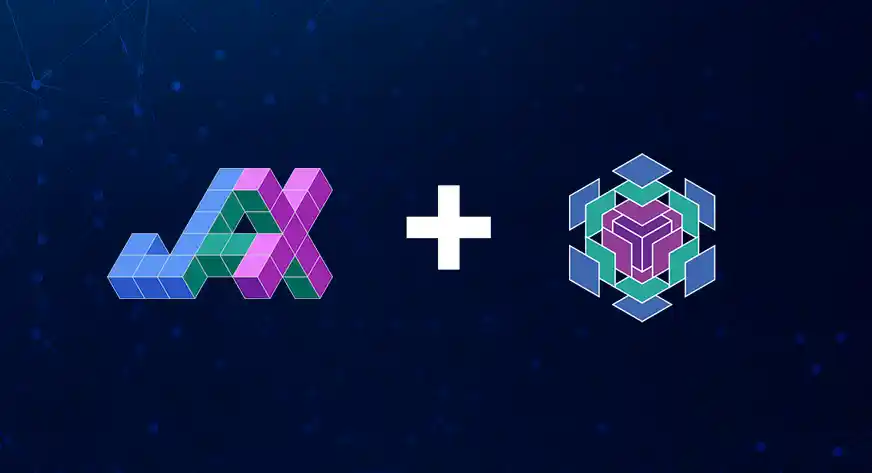

# Building Scalable Machine Learning Models with JAX and FLAX by Henry Ndubuaku

This notebook introduces and walks through JAX/FLAX for Machine Learning Engineers of any level!

**Prerequisites (Pre-Installed in Colab):**
- Python 3.8+
- JAX
- Flax
- Optax
- NumPy
- Torch

# Section 1: NumPy On Sterioids



In [ ]:
import jax
import jax.numpy as jnp
import time
import numpy as np
import torch

def timeit(func):
    """Function decorator which runs a function 10x and calculates the average execution time"""
    def wrapper(*args, **kwargs):
        start = time.time()

        for _ in range(10):
            result = func(*args, **kwargs)

        elapsed = time.time() - start
        print(f"Function '{func.__name__}' executed in {(elapsed/10):.6f} seconds on average")
        return result

    return wrapper

In [ ]:
@timeit
def square_numpy(x):
    return x ** 2

x_np = np.random.uniform(size=(10000, 10000))
_ = square_numpy(x_np)

Function 'square_numpy' executed in 0.130972 seconds on average


In [ ]:
@timeit
def square_torch(x):
    return x ** 2

x_torch = torch.rand(10000, 10000)
_ = square_torch(x_torch)

Function 'square_torch' executed in 0.077408 seconds on average


In [ ]:
@timeit
def square_jax(x):
    return x ** 2

key = jax.random.PRNGKey(0)
x_jnp = jax.random.uniform(key, shape=(10000, 10000))
_ = square_jax(x_jnp)

Function 'square_jax' executed in 0.002265 seconds on average


# Section 2: J = Just-In-Time compilation



1. Operation Fusion:
JIT can combine multiple operations into a single, efficient kernel. This minimizes the creation of intermediate arrays and reduces memory overhead, leading to faster execution.

2. Reduced Python Overhead:
Compiling the function into low-level code, eliminates the overhead associated with the Python interpreter. This is particularly beneficial in tight loops or repeated computations.

3. Hardware-Specific Optimization:
The JIT compiler can generate code tailored to your specific hardware (like CPU, GPU, or TPU), enabling better use of vectorized instructions and parallel execution.

4. Static Analysis and Optimizations:
The compiler performs static analysis of the code, enabling optimizations such as constant folding, dead code elimination, and inlining of functions, which further enhances performance.

5. Caching of Compiled Code:
Once a function is compiled, subsequent calls reuse the compiled code, avoiding repeated compilation overhead.

In [ ]:
@timeit
def square(x):
    return x ** 2

jitted_square = jax.jit(square)
_ = square(x_jnp)
_ = jitted_square(x_jnp)

Function 'square' executed in 0.000381 seconds on average
Function 'square' executed in 0.000143 seconds on average


In [ ]:
@timeit
def longer_function(x):
    """The more operations involved, the better its benefits"""
    x = x @ x.T
    return x ** 2

jitted_longer_function = jax.jit(longer_function)
_ = longer_function(x_jnp)
_ = jitted_longer_function(x_jnp)

Function 'longer_function' executed in 0.026375 seconds on average
Function 'longer_function' executed in 0.000253 seconds on average


# Section 3: A = Automatic Differentiation


Under the hood, JAX uses reverse-mode automatic differentiation to compute gradients efficiently. When you apply jax.value_and_grad to a function, it returns a new function that, when called, computes both the original function's output (its value) and the gradient with respect to its inputs.

In [ ]:
def f(x):
    return x**3 - 3*x**2 + 2*x

grad_f = jax.grad(f)

x_val = 3.7
print("Function value at x =", x_val, ":", f(x_val))
print("Gradient at x =", x_val, ":", grad_f(x_val))

Function value at x = 3.7 : 16.982999999999997
Gradient at x = 3.7 : 20.869999


In [ ]:
@jax.value_and_grad
def f(x):
    return x**3 - 3*x**2 + 2*x

x_val = 3.7
output, derivative = f(x_val)

print("Function value at x =", x_val, ":", output)
print("Gradient at x =", x_val, ":", derivative)

Function value at x = 3.7 : 16.983004
Gradient at x = 3.7 : 20.869999


# Section 4: X = XLA Compiler

XLA (Accelerated Linear Algebra) is the backend that optimizes JAX computations. It lowers functions/model into a unified representation (StableHLO). Image creating your PyTorch model, and executing as Jax!

In [ ]:
def f(x, y):
    return jnp.dot(x, y) + jnp.sin(x)

key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (500, 500))
y = jax.random.normal(key, (500, 500))

lowered = jax.jit(f).lower(x, y)
hlo_computation = lowered.compiler_ir("hlo")

print(hlo_computation.as_hlo_text())

HloModule jit_f, entry_computation_layout={(f32[500,500]{1,0}, f32[500,500]{1,0})->f32[500,500]{1,0}}, frontend_attributes={xla.sdy.meshes={}}

ENTRY main.6 {
  Arg_0.1 = f32[500,500]{1,0} parameter(0)
  Arg_1.2 = f32[500,500]{1,0} parameter(1)
  dot.3 = f32[500,500]{1,0} dot(Arg_0.1, Arg_1.2), lhs_contracting_dims={1}, rhs_contracting_dims={0}
  sine.4 = f32[500,500]{1,0} sine(Arg_0.1)
  ROOT add.5 = f32[500,500]{1,0} add(dot.3, sine.4)
}




In [ ]:
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (500, 500))
y = jax.random.normal(key, (500, 500))

result = f(x, y)

# Section 5: JAX is Functional :(

- **Immutability:**  
  Data in JAX is immutable. Once created, arrays and other objects cannot be modified. This eliminates side effects and makes reasoning about code behavior easier.

In [ ]:
# Wrong
x = jnp.array([1, 2, 3])
x[0] = 10
print(x)

In [ ]:
# Correct
x = jnp.array([1, 2, 3])
x = x.at[0].set(10)
print(x)

[10  2  3]


- **Pure Functions:**  
  Functions in JAX are expected to be *pure*, meaning they always produce the same output for the same inputs and do not alter any external state. Pure functions are easier to debug and are essential for reliable transformations like just-in-time compilation (`jit`) and automatic differentiation (`grad`).

In [ ]:
counter = 0

def impure_function(x):
    global counter        # Access and modify the external state
    counter += 1          # Side effect: modifies global variable
    return x + counter    # Will not return the same result when called again

def pure_function(x, counter):
    return x + counter    # Does affect or rely on external variables and returns same results

- **Explicit State Management:**  
  Instead of relying on hidden, mutable state (like NumPy's global random state), JAX requires that all state changes be explicit. For example, random number generation in JAX is handled via passing and updating PRNG keys, ensuring that randomness is reproducible and free of side effects.

In [ ]:
# Create an initial PRNG key
key = jax.random.PRNGKey(0)

# Split the key to produce independent subkeys
subkey, key = jax.random.split(key)

# Use the subkey to generate a random array
random_array = jax.random.uniform(subkey, shape=(3,))

- **Function Composition:**  
  The functional paradigm encourages building small, composable functions. In JAX, higher-order functions like `jit`, `vmap`, and `grad` transform these small functions, enabling optimizations and parallelism without compromising purity.

In [ ]:
def f(x):
    return x ** 2

def g(x):
    return x + x

composed = jax.jit(lambda x: g(f(x)))
print("Computes g(f(2)) = (2^2) + (2^2) = ", composed(2.0))

Computes g(f(2)) = (2^2) + (2^2) =  8.0


In [ ]:
vectorized_composed = jax.vmap(composed)
x_array = jnp.array([1,2,3,4,5])
print("Applies function to each element of x_array: ", vectorized_composed(x_array))

Applies function to each element of x_array:  [ 2  8 18 32 50]


# Section 6: Flax & Optax

In [ ]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax.training.train_state import TrainState
import numpy as np

In [ ]:
class SimpleMLP(nn.Module):
    hidden_features: int = 32

    def setup(self):
        self.dense1 = nn.Dense(self.hidden_features)
        self.dense2 = nn.Dense(1)

    def __call__(self, x):
        x = self.dense1(x)
        x = nn.relu(x)
        x = self.dense2(x)
        return x

def create_train_state(rng, learning_rate, input_shape):
    model = SimpleMLP()
    params = model.init(rng, jnp.ones(input_shape))
    optimizer = optax.adam(learning_rate)
    return TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)


def loss_fn(params, apply_fn, x, y):
    preds = apply_fn(params, x)
    loss = jnp.mean((preds - y) ** 2)
    return loss


@jax.jit
def train_step(state, x, y):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss


In [ ]:
def train_model(num_epochs=10, batch_size=32, learning_rate=1e-3):
    # Create training state
    rng = jax.random.PRNGKey(0)
    input_dim = 10
    state = create_train_state(rng, learning_rate, (1, input_dim))

    # Our dummy data
    num_samples = 10240
    X = np.random.randn(num_samples, input_dim).astype(np.float32)
    true_w = np.random.randn(input_dim, 1).astype(np.float32)
    y = X @ true_w + np.random.randn(num_samples, 1).astype(np.float32) * 0.1

    # Epoch iteration
    for epoch in range(num_epochs):
        perm = np.random.permutation(num_samples)
        X, y = X[perm], y[perm]
        epoch_loss = 0.0
        num_batches = num_samples // batch_size

        # Batch iteration
        for i in range(num_batches):
            batch_x = X[i * batch_size:(i + 1) * batch_size]
            batch_y = y[i * batch_size:(i + 1) * batch_size]
            state, loss = train_step(state, batch_x, batch_y)
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {epoch_loss / num_batches:.4f}")

    return state

if __name__ == "__main__":
    final_state = train_model()
    params = final_state.params

Epoch 1, Loss: 2.8510
Epoch 2, Loss: 0.0856
Epoch 3, Loss: 0.0509
Epoch 4, Loss: 0.0388
Epoch 5, Loss: 0.0331
Epoch 6, Loss: 0.0295
Epoch 7, Loss: 0.0266
Epoch 8, Loss: 0.0241
Epoch 9, Loss: 0.0217
Epoch 10, Loss: 0.0197


- **Parameters is a simple dictionary**

In [ ]:
print(params)

# Section 7: Performance Optimization

- **PyTrees**: tree-like data structures used in JAX to organise and manage nested collections of data, such as parameters in neural networks. They allow for a uniform interface to traverse, transform, and reduce nested structures—regardless of whether they are dictionaries, lists, tuples, or more complex custom objects. This standardized handling is crucial for efficiently computing gradients, applying transformations, and managing the state of models during training.

In [ ]:
from jax.tree_util import tree_map

def convert_to_fp16(params):

    def convert_leaf(x):
        if isinstance(x, jnp.ndarray):
            return x.astype(jnp.float16)
        return x

    return tree_map(convert_leaf, params)

params = convert_to_fp16(params)

In [ ]:
from jax.tree_util import tree_leaves

num_params = sum(x.size for x in tree_leaves(params))
print(num_params)

385


- **Vmap**

In [ ]:
row, col = 200, 200
x = jnp.arange(row * col).reshape((row,col))

@jax.vmap
def softmax(x):
    x_max = jnp.max(x)
    exp_x = jnp.exp(x - x_max)
    return exp_x / jnp.sum(exp_x)

y = softmax(x)
print(jnp.sum(y, axis=1))

- **Learning Rate Schedules**

In [ ]:
def create_train_state(rng, learning_rate, input_shape):
    model = SimpleMLP()
    params = model.init(rng, jnp.ones(input_shape))

    lr_schedule = optax.exponential_decay(
        init_value=learning_rate,
        transition_steps=10,
        decay_rate=0.99,
        staircase=True
    )

    optimizer = optax.chain(
        optax.adam(learning_rate=1E-1),
        optax.scale_by_schedule(lr_schedule),
        optax.scale(-1.0)
    )

    return TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

- **Gradient Accumulation**

In [ ]:
def loss_fn(params, apply_fn, x, y):
    preds = apply_fn(params, x)
    loss = jnp.mean((preds - y) ** 2)
    return loss

@jax.jit
def compute_grads(state, x, y):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, x, y)
    return loss, grads

def train_model(num_epochs=10, batch_size=32, accum_steps=4, base_learning_rate=1e-3):
    rng = jax.random.PRNGKey(0)
    input_dim = 10
    state = create_train_state(rng, base_learning_rate, (1, input_dim))

    # Our dumy data
    num_samples = 10240
    X = np.random.randn(num_samples, input_dim).astype(np.float32)
    true_w = np.random.randn(input_dim, 1).astype(np.float32)
    y = X @ true_w + np.random.randn(num_samples, 1).astype(np.float32) * 0.1

    num_batches = num_samples // batch_size

    for epoch in range(num_epochs):
        perm = np.random.permutation(num_samples)
        X, y = X[perm], y[perm]
        epoch_loss = 0.0

        # Initialize accumulation variables.
        accum_grads = None
        accum_loss = 0.0
        counter = 0

        for i in range(num_batches):
            batch_x = X[i * batch_size:(i + 1) * batch_size]
            batch_y = y[i * batch_size:(i + 1) * batch_size]
            loss, grads = compute_grads(state, batch_x, batch_y)
            accum_loss += loss
            counter += 1

            # Accumulate gradients.
            if accum_grads is None:
                accum_grads = grads
            else:
                accum_grads = jax.tree_util.tree_map(lambda a, b: a + b, accum_grads, grads)

            # When we've accumulated enough steps, update the model.
            if counter % accum_steps == 0:
                # Average the gradients.
                accum_grads = jax.tree_util.tree_map(lambda g: g / accum_steps, accum_grads)
                state = state.apply_gradients(grads=accum_grads)
                accum_grads = None  # Reset for next accumulation cycle.
                counter = 0

        # If any gradients are left over, update with the averaged gradients.
        if counter > 0 and accum_grads is not None:
            accum_grads = jax.tree_util.tree_map(lambda g: g / counter, accum_grads)
            state = state.apply_gradients(grads=accum_grads)

        avg_loss = accum_loss / num_batches
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return state

if __name__ == "__main__":
    final_state = train_model()
    params = final_state.params

# Section 8: Sharding and Distribution

In [ ]:
num_devices = jax.local_device_count()
print("Number of TPUs", num_devices)

Number of TPUs 8


In [ ]:
# Dummy data
M, N, K = 16, 32, 64
A = jnp.arange(num_devices * M * N, dtype=jnp.float32)
B = jnp.arange(num_devices * N * K, dtype=jnp.float32)

- **Pmap**: Distributes your compute to multiple TPUs.

In [ ]:
@jax.jit
def matmul(a, b):
    return jnp.dot(a, b)

A_reshaped = A.reshape(num_devices, M, N)
B_reshaped = B.reshape(num_devices, N, K)

pmap_matmul = jax.pmap(matmul)
result = pmap_matmul(A_reshaped, B_reshaped)

print("Result shape:", result.shape)

Result shape: (8, 16, 64)


- **Pjit and Mesh**: Are designed for scenarios where you need to carefully control how your computations are distributed and how data is laid out across devices, offering a more customizable alternative to pmap for parallel and distributed computing in JAX.

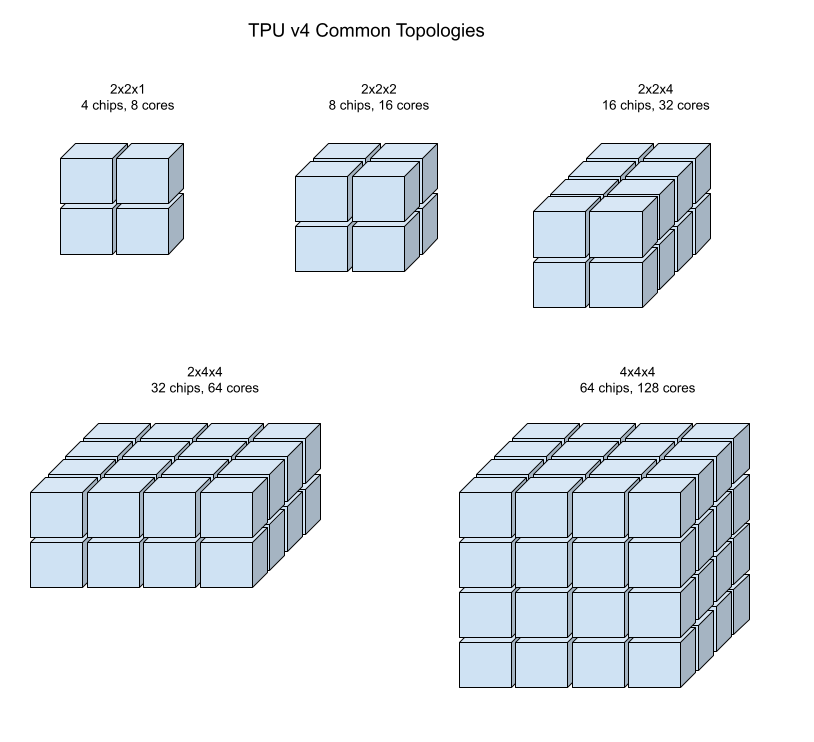


In [ ]:
from jax.experimental.pjit import pjit
from jax.sharding import Mesh, PartitionSpec

def matmul(a, b):
    return jnp.dot(a, b)

devices = np.array(jax.devices())

mesh_x, mesh_y, mesh_z = 2, 2, 2

mesh = Mesh(
    devices.reshape(mesh_x, mesh_y, mesh_z),
    ('mesh_x', 'mesh_y', 'mesh_z')
)

A_partition = PartitionSpec('mesh_x', 'mesh_y', 'mesh_z', None, None)
B_partition = PartitionSpec('mesh_x', 'mesh_y', 'mesh_z', None, None)
out_partition = PartitionSpec('mesh_x', 'mesh_y', 'mesh_z', None, None)

A_reshaped = A.reshape(mesh_x, mesh_y, mesh_z, M, N)
B_reshaped = B.reshape(mesh_x, mesh_y, mesh_z, N, K)

pjit_matmul = pjit(
    matmul,
    in_shardings=(A_partition, B_partition),
    out_shardings=out_partition,
)

with mesh:
    result = pjit_matmul(A_reshaped, B_reshaped)

print("Number of devices:", num_devices)
print("Result shape:", result.shape)
print("")

Number of devices: 8
Result shape: (2, 2, 2, 16, 2, 2, 2, 64)



# Section 9: NanoDL, Maxtext, MaxDiffusion

In [ ]:
!pip install nanodl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
import jax
import nanodl
import jax.numpy as jnp
from nanodl import ArrayDataset, DataLoader
from nanodl import GPT4, GPTDataParallelTrainer

batch_size = 8
num_samples = 8000
max_length = 50
vocab_size = 1000

data = nanodl.uniform(
    shape=(num_samples, max_length),
    minval=0, maxval=vocab_size-1
    ).astype(jnp.int32)


dummy_inputs, dummy_targets = data[:, :-1], data[:, 1:]

dataset = ArrayDataset(dummy_inputs, dummy_targets)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=False
    )

hyperparams = {
    'num_layers': 2,
    'hidden_dim': 128,
    'num_heads': 2,
    'feedforward_dim': 128,
    'dropout': 0.1,
    'vocab_size': vocab_size,
    'embed_dim': 128,
    'max_length': max_length,
    'start_token': 0,
    'end_token': 50,
}

model = GPT4(**hyperparams)

trainer = GPTDataParallelTrainer(
    model,
    dummy_inputs.shape,
    'params.pkl',
    learning_rate=1E-3,
    )

trainer.train(train_loader=dataloader, num_epochs=10)

Number of parameters: 1879292
Number of accelerators: 8
Epoch 1, Train Loss: 6.8678178787231445
Epoch 2, Train Loss: 6.079052925109863
Epoch 3, Train Loss: 5.33558988571167
Epoch 4, Train Loss: 5.048905849456787
Epoch 5, Train Loss: 4.776106357574463
Epoch 6, Train Loss: 4.567427158355713
Epoch 7, Train Loss: 4.424076557159424
Epoch 8, Train Loss: 4.213206768035889
Epoch 9, Train Loss: 3.9109644889831543
Epoch 10, Train Loss: 3.69956636428833


- **Maxtext**

- **Maxdiffusion**